In [1]:
import this

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


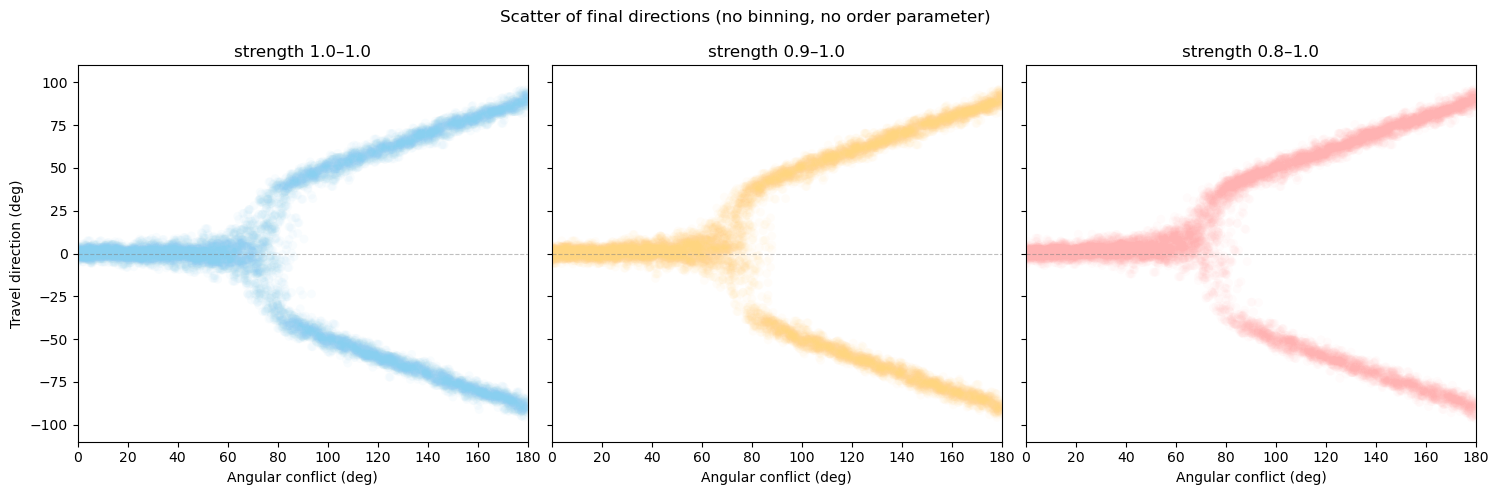

In [2]:
import os, json, h5py
import numpy as np
import matplotlib.pyplot as plt

# ==== CONFIG ====
sim_dirs = {
    "strength 1.0–1.0": "/Users/apaula/src/SimulationResults/20250812_183145_sweep_angles_symmetric_kappa_10_10_strength_1.0_1.0_prerun",
    "strength 0.9–1.0": "/Users/apaula/src/SimulationResults/20250811_183013_sweep_angles_symmetric_kappa_10_10_strength_0.9_1.0_prerun",
    "strength 0.8–1.0": "/Users/apaula/src/SimulationResults/20251014_151802_sweep_angles_symmetric_kappa_10_10_strength_0.8_1.0_prerun"
}
h5_name = "experiment.h5"

style = {
    "strength 0.8–1.0": {"pt": "#FFB2B2"},
    "strength 1.0–1.0": {"pt": "#89CFF0"},
    "strength 0.9–1.0": {"pt": "#FFD580"},
}

# ---------- Helpers ----------
def _read_ds(g, name):
    if name not in g:
        return None
    ds = g[name]
    enc = ds.attrs.get("encoding", None)
    if enc == b"json-utf8" or enc == "json-utf8":
        payload = bytes(ds[:].tolist())
        return np.array(json.loads(payload.decode("utf-8")))
    return ds[:]

def load_simulation_angles(h5_path):
    """Return dict: angle(deg) -> list of final_direction_deg for a single sim file."""
    out = {}
    with h5py.File(h5_path, "r") as f:
        runs = f["runs"]
        for run_name in runs:
            g = runs[run_name]
            angle_attr = float(g.attrs["angle"])
            avg_dir = _read_ds(g, "average_direction")
            if avg_dir is None or len(avg_dir) == 0:
                continue
            # detect radians vs degrees
            if abs(angle_attr) <= np.pi and np.nanmax(np.abs(avg_dir)) <= np.pi + 1e-6:
                angle_deg = float(np.degrees(angle_attr))
                final_direction_deg = float(np.degrees(np.array(avg_dir, dtype=float)[-1]))
            else:
                angle_deg = float(angle_attr)
                final_direction_deg = float(np.array(avg_dir, dtype=float)[-1])
            out.setdefault(angle_deg, []).append(final_direction_deg)
    if len(out) == 0:
        raise ValueError(f"No runs found in {h5_path}")
    return out

# ---------- Load simulations ----------
sim_data = {}
for name, folder in sim_dirs.items():
    h5_path = os.path.join(folder, h5_name)
    sim_data[name] = load_simulation_angles(h5_path)

# ---------- Scatter plots (no binning, no order parameter) ----------
n_exp = len(sim_data)
fig, axes = plt.subplots(1, n_exp, figsize=(5*n_exp, 5), sharey=True)

if n_exp == 1:
    axes = [axes]

for ax, (name, dct) in zip(axes, sim_data.items()):
    angles_all, dirs_all = [], []
    for a, vals in dct.items():
        angles_all.extend([a] * len(vals))
        dirs_all.extend(vals)

    ax.scatter(angles_all, dirs_all, s=40, alpha=0.05,
               color=style[name]["pt"], edgecolors="none")
    
    ax.axhline(0, color="grey", lw=0.8, ls="--", alpha=0.5)
    ax.set_title(name)
    ax.set_xlabel("Angular conflict (deg)")
    ax.set_xlim(0, 180)

axes[0].set_ylabel("Travel direction (deg)")
axes[0].set_ylim(-110, 110)

fig.suptitle("Scatter of final directions (no binning, no order parameter)")
fig.tight_layout()
plt.show()


In [3]:
import numpy as np
import pandas as pd
from diptest import diptest

# --- collect columns explicitly ---
exps, confs, dirs_ = [], [], []
for exp_name, dct in sim_data.items():
    for angle, vals in dct.items():
        a = float(np.asarray(angle).reshape(-1)[0])  # force scalar float64
        for d in vals:
            dd = float(np.asarray(d).reshape(-1)[0])
            if np.isfinite(a) and np.isfinite(dd):
                exps.append(str(exp_name))
                confs.append(a)
                dirs_.append(dd)

# --- construct DataFrame with explicit dtypes ---
df = pd.DataFrame({
    "experiment": np.array(exps, dtype=object),
    "angular_conflict": np.array(confs, dtype=np.float64),
    "travel_direction": np.array(dirs_, dtype=np.float64),
})

# optional hygiene: drop any NaNs/infs just in case
df = df.replace([np.inf, -np.inf], np.nan).dropna(
    subset=["angular_conflict", "travel_direction"]
)

# ---- Bin angular conflict ----
n_bins = 30
df["conflict_bin"] = pd.cut(df["angular_conflict"], bins=n_bins)

# ---- Run dip test per bin per experiment ----
results = []
for (exp, bin_label), group in df.groupby(["experiment", "conflict_bin"]):
    if len(group) < 10:
        continue
    travel_dirs = group["travel_direction"].to_numpy(dtype=np.float64, copy=False)
    dip, pval = diptest(travel_dirs)
    results.append({
        "experiment": exp,
        "conflict_bin": str(bin_label),
        "n_samples": len(travel_dirs),
        "dip_stat": dip,
        "p_value": pval,
        "modality": "unimodal" if pval > 0.05 else "multi-modal",
    })

results_df = pd.DataFrame(results)
print(results_df)


          experiment    conflict_bin  n_samples  dip_stat   p_value  \
0   strength 0.8–1.0    (-0.18, 6.0]        300  0.022137  0.404572   
1   strength 0.8–1.0     (6.0, 12.0]        300  0.031849  0.033097   
2   strength 0.8–1.0    (12.0, 18.0]        325  0.022958  0.282480   
3   strength 0.8–1.0    (18.0, 24.0]        275  0.020639  0.611060   
4   strength 0.8–1.0    (24.0, 30.0]        325  0.016923  0.806235   
..               ...             ...        ...       ...       ...   
85  strength 1.0–1.0  (150.0, 156.0]        300  0.225871  0.000000   
86  strength 1.0–1.0  (156.0, 162.0]        300  0.225854  0.000000   
87  strength 1.0–1.0  (162.0, 168.0]        300  0.225471  0.000000   
88  strength 1.0–1.0  (168.0, 174.0]        300  0.223875  0.000000   
89  strength 1.0–1.0  (174.0, 180.0]        300  0.223142  0.000000   

       modality  
0      unimodal  
1   multi-modal  
2      unimodal  
3      unimodal  
4      unimodal  
..          ...  
85  multi-modal  
86 

/var/folders/fp/69w3242x183607ffnzm682500000gp/T/ipykernel_36074/3699886309.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for (exp, bin_label), group in df.groupby(["experiment", "conflict_bin"]):


Saved: /Users/apaula/src/VRDataAnalysis/Ants/ridgelines_strength_1.0-1.0.png


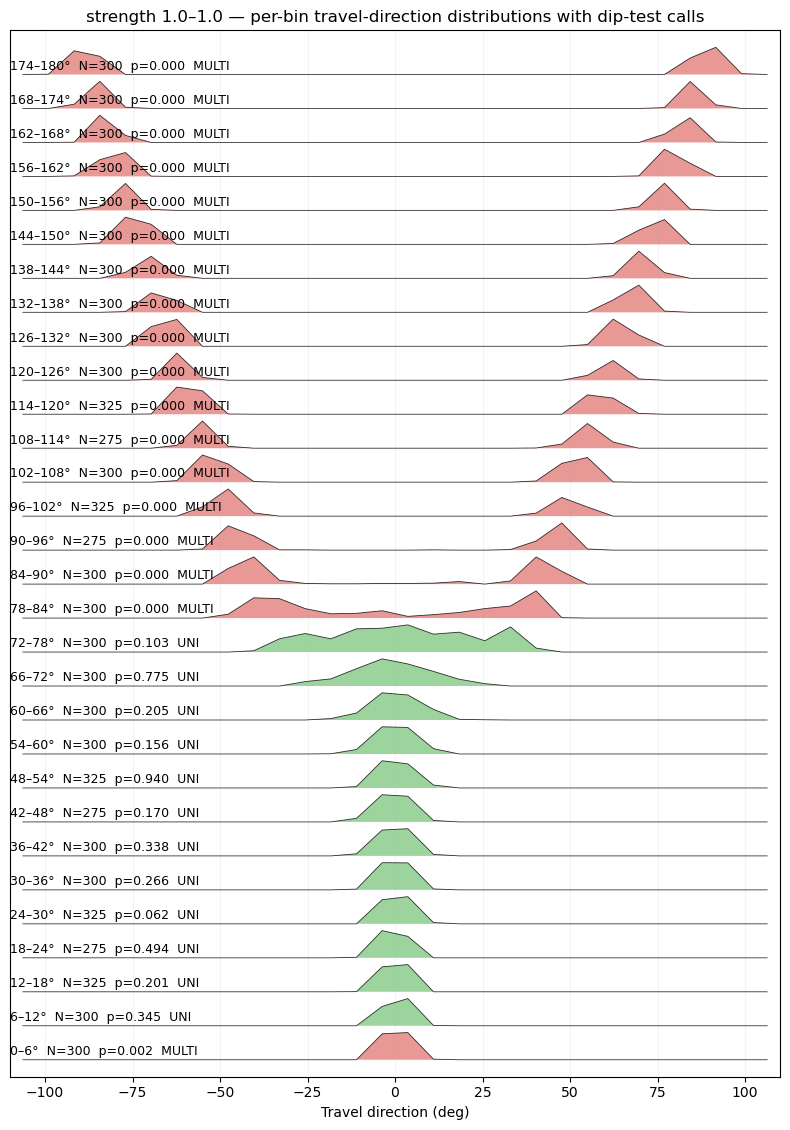

Saved: /Users/apaula/src/VRDataAnalysis/Ants/ridgelines_strength_0.9-1.0.png


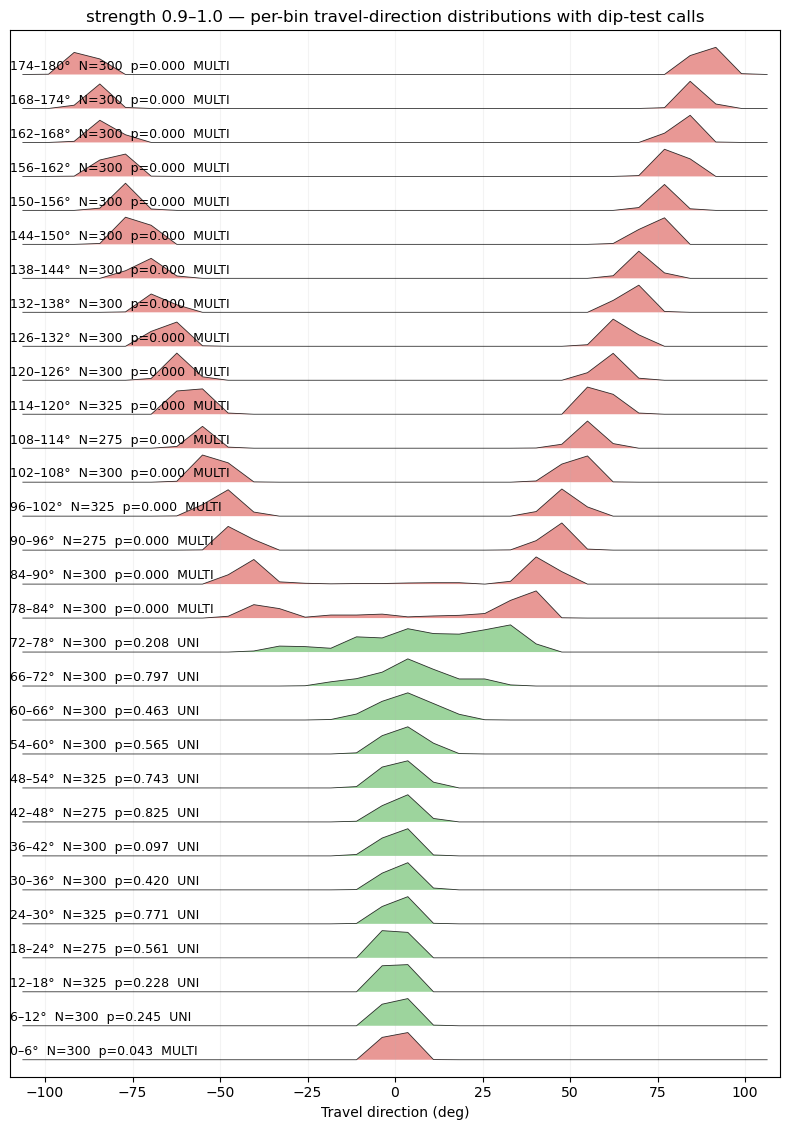

Saved: /Users/apaula/src/VRDataAnalysis/Ants/ridgelines_strength_0.8-1.0.png


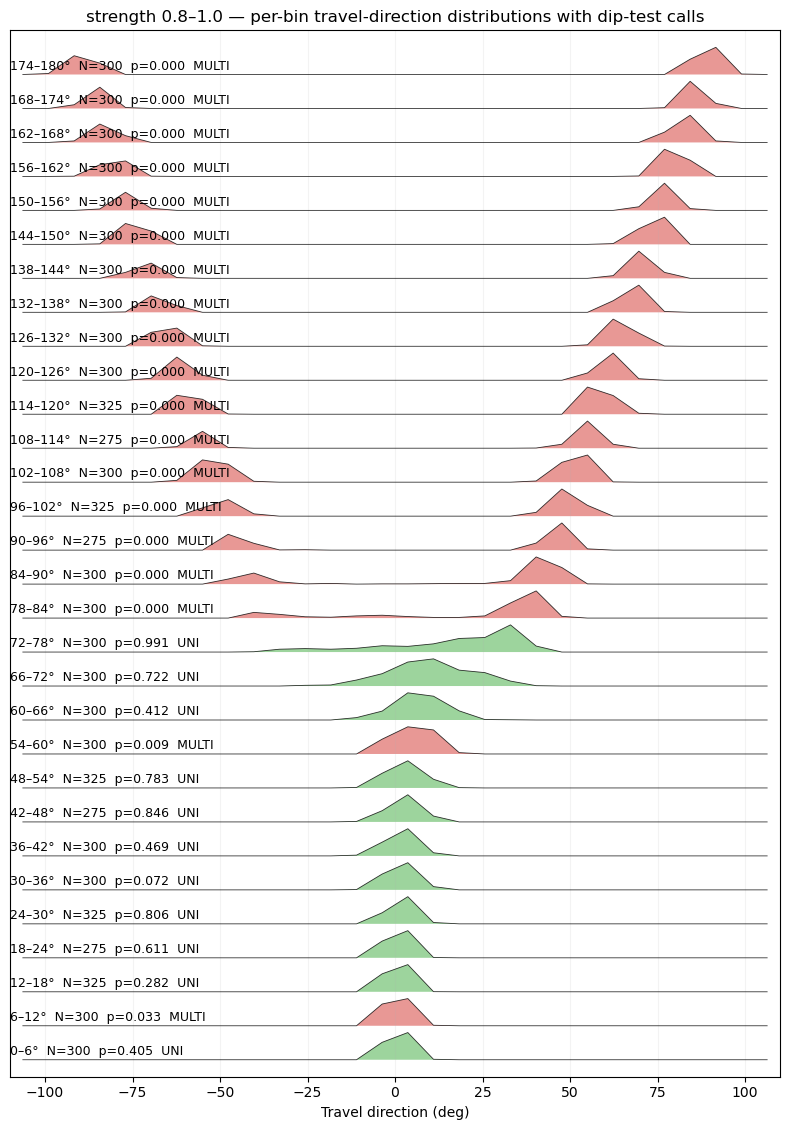

      experiment   conflict_bin  n_samples  dip_stat  p_value    modality
strength 0.8–1.0   (-0.18, 6.0]        300  0.022137 0.404572    unimodal
strength 0.8–1.0    (6.0, 12.0]        300  0.031849 0.033097 multi-modal
strength 0.8–1.0   (12.0, 18.0]        325  0.022958 0.282480    unimodal
strength 0.8–1.0   (18.0, 24.0]        275  0.020639 0.611060    unimodal
strength 0.8–1.0   (24.0, 30.0]        325  0.016923 0.806235    unimodal
strength 0.8–1.0   (30.0, 36.0]        300  0.029229 0.072099    unimodal
strength 0.8–1.0   (36.0, 42.0]        300  0.021370 0.469319    unimodal
strength 0.8–1.0   (42.0, 48.0]        275  0.017761 0.845528    unimodal
strength 0.8–1.0   (48.0, 54.0]        325  0.017194 0.783245    unimodal
strength 0.8–1.0   (54.0, 60.0]        300  0.035279 0.009382 multi-modal
strength 0.8–1.0   (60.0, 66.0]        300  0.022043 0.412492    unimodal
strength 0.8–1.0   (66.0, 72.0]        300  0.018570 0.722442    unimodal
strength 0.8–1.0   (72.0, 78.0]       

In [4]:
# ==== Visualize all per-bin distributions with modality labels (ridgelines) ====
import numpy as np
import matplotlib.pyplot as plt

# Build a lookup from your results (use strings for bin keys to match easily)
res_map = {}
for r in results_df.to_dict(orient="records"):
    res_map[(r["experiment"], r["conflict_bin"])] = {
        "p": r["p_value"],
        "dip": r["dip_stat"],
        "modality": r["modality"],
        "n": r["n_samples"],
    }

# Helper: consistent x-range per experiment
def x_range_for_exp(df_exp):
    # Use broad, stable limits (your earlier plot uses [-110, 110])
    lo = np.nanmin(df_exp["travel_direction"].values)
    hi = np.nanmax(df_exp["travel_direction"].values)
    # pad a bit
    pad = 0.05 * (hi - lo if hi > lo else 1.0)
    return (min(-110, lo - pad), max(110, hi + pad))

# Plot one experiment as a ridgeline
def plot_experiment_ridgelines(exp_name, df_exp, min_n=10, bins_for_travel=30):
    # Get ordered conflict bins actually present
    # (df['conflict_bin'] is a pandas.Interval)
    ordered_bins = sorted(
        [b for b in df_exp["conflict_bin"].dropna().unique()],
        key=lambda iv: iv.left
    )
    # Filter to those we tested (n >= min_n) based on your res_map
    ordered_bins = [
        b for b in ordered_bins
        if (exp_name, str(b)) in res_map and res_map[(exp_name, str(b))]["n"] >= min_n
    ]
    if not ordered_bins:
        print(f"[{exp_name}] No bins with N >= {min_n}.")
        return

    xlo, xhi = x_range_for_exp(df_exp)
    width = 8
    height_per_bin = 0.33
    fig, ax = plt.subplots(figsize=(width, max(3, height_per_bin * len(ordered_bins) + 1.5)))

    # vertical spacing
    offsets = np.arange(len(ordered_bins))  # one row per bin
    yscale = 0.8  # target max ridge height

    for i, iv in enumerate(ordered_bins):
        g = df_exp.loc[df_exp["conflict_bin"] == iv, "travel_direction"].dropna().values
        key = (exp_name, str(iv))
        info = res_map[key]
        label = "UNI" if info["modality"] == "unimodal" else "MULTI"
        color = "#5cb85c" if label == "UNI" else "#d9534f"

        # histogram density for the ridge
        counts, edges = np.histogram(g, bins=bins_for_travel, range=(xlo, xhi), density=True)
        centers = 0.5 * (edges[:-1] + edges[1:])
        dens = counts

        # scale density to fit nicely in the band
        maxd = np.max(dens) if dens.size else 1.0
        scale = (yscale / maxd) if maxd > 0 else 1.0
        y = offsets[i] + dens * scale

        # filled ridge
        ax.fill_between(centers, offsets[i], y, facecolor=color, alpha=0.6, linewidth=0)
        # outline
        ax.plot(centers, y, color="black", lw=0.6, alpha=0.8)

        # left-side label
        ax.text(
            xlo, offsets[i] + 0.05,
            f"{int(iv.left)}–{int(iv.right)}°  "
            f"N={info['n']}  p={info['p']:.3f}  {label}",
            ha="left", va="bottom", fontsize=9
        )

    # cosmetics
    ax.set_xlim(xlo, xhi)
    ax.set_ylim(-0.5, len(ordered_bins) - 0.5 + yscale)
    ax.set_yticks([])  # hide y ticks (rows are bins)
    ax.set_xlabel("Travel direction (deg)")
    ax.set_title(f"{exp_name} — per-bin travel-direction distributions with dip-test calls")
    ax.grid(axis="x", alpha=0.15)

    fig.tight_layout()
    out = f"ridgelines_{exp_name.replace(' ', '_').replace('–', '-')}.png"
    fig.savefig(out, dpi=200, bbox_inches="tight")
    print(f"Saved: {os.path.abspath(out)}")
    plt.show()

# ---- Make one figure per experiment ----
for exp in df["experiment"].unique():
    plot_experiment_ridgelines(exp, df[df["experiment"] == exp], min_n=10, bins_for_travel=30)

# ---- Also print a compact summary table, sorted by bin ----
summary = results_df.copy()
# sort bins by their left edge for readability
def _left(s):
    try:
        return float(s.split(",")[0].split("(")[-1].split("[")[-1])
    except Exception:
        return np.inf
summary = summary.sort_values(["experiment"], kind="stable")
summary = pd.concat(
    [g.sort_values(by="conflict_bin", key=lambda col: col.map(_left), kind="stable")
     for _, g in summary.groupby("experiment")],
    ignore_index=True
)
print(summary.to_string(index=False))


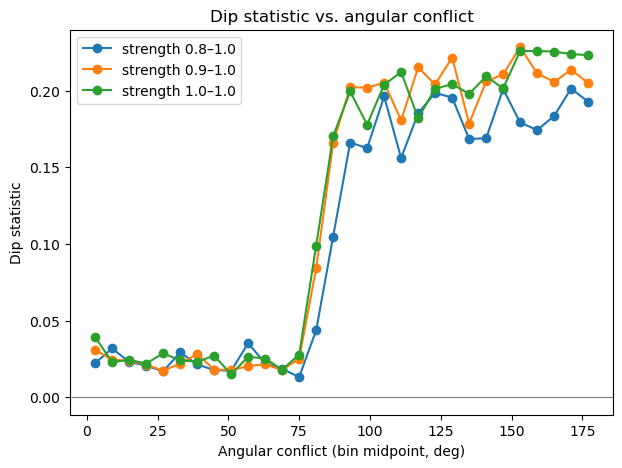

In [5]:
import matplotlib.pyplot as plt

# helper: extract numeric midpoint from conflict_bin string
def bin_midpoint(bin_str):
    # e.g. "(30.0, 36.0]" -> midpoint 33
    nums = bin_str.strip("()[]").split(",")
    left, right = map(float, nums)
    return 0.5 * (left + right)

results_df["bin_mid"] = results_df["conflict_bin"].apply(bin_midpoint)

# plot dip statistic vs. conflict bin midpoint
fig, ax = plt.subplots(figsize=(7,5))
for exp, group in results_df.groupby("experiment"):
    ax.plot(group["bin_mid"], group["dip_stat"], marker="o", label=exp)
    
ax.axhline(0, color="grey", lw=0.8)
ax.set_xlabel("Angular conflict (bin midpoint, deg)")
ax.set_ylabel("Dip statistic")
ax.set_title("Dip statistic vs. angular conflict")
ax.legend()
plt.show()


In [6]:
import numpy as np
from sklearn.neighbors import KernelDensity

# ---------------- Silverman test utilities ----------------

def _count_modes_from_grid(x_grid, density_values, eps=1e-9):
    """
    Count local maxima on a 1D grid. A mode is a point where
    the discrete derivative changes sign + -> -.
    """
    y = np.asarray(density_values)
    # smooth tiny numerical jitters
    y = np.maximum(y, 0)
    # discrete differences
    dy = np.diff(y)
    # positions where derivative goes from + to -
    sgn = np.sign(dy)
    # compress repeated signs
    sgn[sgn == 0] = np.nan
    sgn = np.interp(np.arange(len(sgn)), np.flatnonzero(~np.isnan(sgn)), sgn[~np.isnan(sgn)])
    mode_idxs = np.where((sgn[:-1] > 0) & (sgn[1:] < 0))[0] + 1
    # filter out tiny bumps
    return int(np.sum(y[mode_idxs] > eps))

def _kde_on_grid(x, bandwidth, grid, kernel="gaussian"):
    kde = KernelDensity(kernel=kernel, bandwidth=bandwidth)
    kde.fit(x[:, None])
    log_dens = kde.score_samples(grid[:, None])
    return np.exp(log_dens)

def _critical_bandwidth(x, k=1, grid_size=512, h_low=None, h_high=None, tol=1e-3, max_iter=40):
    """
    Find the smallest bandwidth h such that KDE has <= k modes (Gaussian kernel).
    Uses binary search between h_low and h_high.
    """
    x = np.asarray(x, dtype=float)
    x = x[~np.isnan(x)]
    n = len(x)
    if n < 3:
        return np.nan

    # standardize to improve numerical stability (scale only, keep shape)
    xs = (x - np.mean(x)) / (np.std(x) + 1e-12)

    # grid over a padded range
    lo, hi = np.min(xs), np.max(xs)
    pad = 0.1 * (hi - lo if hi > lo else 1.0)
    grid = np.linspace(lo - pad, hi + pad, grid_size)

    # sensible bandwidth bounds relative to data scale
    if h_low is None:
        h_low = (hi - lo) / (grid_size * 2.0) + 1e-4
    if h_high is None:
        h_high = 2.0 * (hi - lo + 1e-6)

    # ensure upper bound is large enough to collapse modes
    for _ in range(10):
        dens = _kde_on_grid(xs, h_high, grid)
        modes = _count_modes_from_grid(grid, dens)
        if modes <= k:
            break
        h_high *= 2.0  # expand until we can get <= k modes

    # binary search
    it = 0
    while (h_high - h_low) > tol and it < max_iter:
        it += 1
        h_mid = 0.5 * (h_low + h_high)
        dens = _kde_on_grid(xs, h_mid, grid)
        modes = _count_modes_from_grid(grid, dens)
        if modes <= k:
            h_high = h_mid
        else:
            h_low = h_mid

    # convert back to original scale: since xs were standardized, bandwidth rescales by std
    scale = np.std(x) + 1e-12
    return h_high * scale

def silverman_test(x, k=1, B=200, grid_size=512, random_state=None):
    """
    Classic Silverman's test for H0: number of modes <= k vs H1: > k.
    Returns (h_obs, p_value).

    Steps:
    1) Compute critical bandwidth h_k(x).
    2) Smoothed bootstrap: draw x* by resampling x with replacement and adding N(0, h_obs^2).
    3) For each bootstrap sample, compute h_k(x*).
    4) p = mean(h_k(x*) >= h_obs).
    """
    rng = np.random.default_rng(random_state)
    x = np.asarray(x, dtype=float)
    x = x[~np.isnan(x)]
    n = len(x)
    if n < 3:
        return np.nan, np.nan

    # observed critical bandwidth
    h_obs = _critical_bandwidth(x, k=k, grid_size=grid_size)

    if not np.isfinite(h_obs) or h_obs <= 0:
        return h_obs, np.nan

    # smoothed bootstrap
    hk_boot = []
    for _ in range(B):
        x_resample = rng.choice(x, size=n, replace=True)
        z = x_resample + rng.normal(loc=0.0, scale=h_obs, size=n)
        hk = _critical_bandwidth(z, k=k, grid_size=grid_size)
        hk_boot.append(hk)

    hk_boot = np.asarray(hk_boot)
    # p-value: proportion of bootstrap critical bandwidths >= observed
    p = float(np.mean(hk_boot >= h_obs))
    return h_obs, p


In [7]:
# Using your existing df with columns: experiment, conflict_bin, travel_direction
silverman_results = []
for (exp, bin_label), group in df.groupby(["experiment", "conflict_bin"]):
    x = group["travel_direction"].dropna().values
    if x.size < 10:
        continue
    # k=1 tests "unimodal?" ; use k=2 to test "at most bimodal?"
    h_obs, pval = silverman_test(x, k=1, B=200, grid_size=512, random_state=42)
    silverman_results.append({
        "experiment": exp,
        "conflict_bin": str(bin_label),
        "n_samples": x.size,
        "h_crit": h_obs,
        "p_value": pval,
        "modality": "unimodal" if pval > 0.05 else "multi-modal"
    })

silverman_df = pd.DataFrame(silverman_results)
print(silverman_df.sort_values(["experiment", "conflict_bin"]).to_string(index=False))


/var/folders/fp/69w3242x183607ffnzm682500000gp/T/ipykernel_36074/3315951450.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for (exp, bin_label), group in df.groupby(["experiment", "conflict_bin"]):


      experiment   conflict_bin  n_samples    h_crit  p_value    modality
strength 0.8–1.0   (-0.18, 6.0]        300  0.940161    0.420    unimodal
strength 0.8–1.0 (102.0, 108.0]        300 47.532627    0.000 multi-modal
strength 0.8–1.0 (108.0, 114.0]        275 42.881326    0.000 multi-modal
strength 0.8–1.0 (114.0, 120.0]        325 49.291536    0.000 multi-modal
strength 0.8–1.0   (12.0, 18.0]        325  0.581596    0.675    unimodal
strength 0.8–1.0 (120.0, 126.0]        300 54.591321    0.000 multi-modal
strength 0.8–1.0 (126.0, 132.0]        300 55.585331    0.000 multi-modal
strength 0.8–1.0 (132.0, 138.0]        300 53.851429    0.000 multi-modal
strength 0.8–1.0 (138.0, 144.0]        300 56.494248    0.000 multi-modal
strength 0.8–1.0 (144.0, 150.0]        300 64.161716    0.000 multi-modal
strength 0.8–1.0 (150.0, 156.0]        300 62.759775    0.000 multi-modal
strength 0.8–1.0 (156.0, 162.0]        300 64.447425    0.000 multi-modal
strength 0.8–1.0 (162.0, 168.0]       

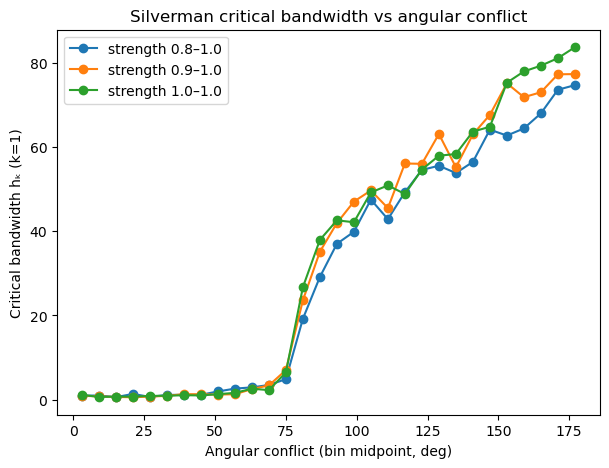

In [10]:
def bin_midpoint(s):
    nums = s.strip("()[]").split(",")
    left, right = map(float, nums)
    return 0.5 * (left + right)

silverman_df["bin_mid"] = silverman_df["conflict_bin"].apply(bin_midpoint)

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(7,5))
for exp, g in silverman_df.groupby("experiment"):
    ax.plot(g["bin_mid"], g["h_crit"], marker="o", label=exp)
ax.set_xlabel("Angular conflict (bin midpoint, deg)")
ax.set_ylabel("Critical bandwidth h\u2096 (k=1)")
ax.set_title("Silverman critical bandwidth vs angular conflict")
ax.legend()
plt.show()
